In [ ]:
#1 UNE FOIS
# la biblithèque albumentations sert pour la data augmentation des radios
!pip install opencv-python-headless==4.5.2.52
!pip install -U albumentations




In [ ]:
#2 
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import os
import pathlib
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import cm

cudnn.benchmark = True

In [ ]:
# 3
# dossier des images
dataset_directory = os.path.join(os.environ["HOME"], "/content/drive/MyDrive/PTRANS2/Dev/data/Verite_terrain")

In [ ]:
# 4
# dossier des radios
images_directory = os.path.join(dataset_directory, "Radios")

In [ ]:
# 5
# dossier des masques des coeurs
masks_directory_C = os.path.join(dataset_directory, "Coeurs")

In [ ]:
# 6
# dossier des masques des vertébres
masks_directory_V = os.path.join(dataset_directory, "Vertebres")

In [ ]:
# 7
# dossier des masques des Process épineux
masks_directory_P = os.path.join(dataset_directory, "Process_epineux")

In [ ]:
# 8
# liste des fichiers des radios 
images_filenames = list(sorted(os.listdir(images_directory)))


In [ ]:
# 9
# mélange aléatoire des fichiers des radios 
random.seed(42)
random.shuffle(images_filenames)

In [ ]:
# 10
# partager les radios en training set (294), validation set (10) et testing set (10 : 5 à partir du training set et 5 à partir du validation set)
train_images_filenames = images_filenames[:294]
val_images_filenames = images_filenames[294:]
test_images_filenames= train_images_filenames[:5] + val_images_filenames[-5:]
len(train_images_filenames),len(val_images_filenames),len(test_images_filenames)

(294, 12, 10)

In [ ]:
#11
# on ajouté 2 nouvelles radios
#on voit bien l'ajout des 2 radios qu'on a pris d'internet "radiography-chien.jpg" et "radio 7.jpg"
#(les modèles ne se sont pas entrainées sur ces dernieres et qui ont été ajoutés au dataset sous le dossier radios dans verite terrain)
# on les a ajoutées pour tester nos IA sur des radios quelconques

test_images_filenames

['THALES_3543DR_Chien_9.jpg',
 'THALES_3543DR_Chien_7.jpg',
 'THALES_3543W_Chien_76.jpg',
 '20180518101933.012345.335_processed.png',
 'iRay_Venu1717X_Chat_14.jpg',
 'THALES_3543W_Chat_53.jpg',
 'THALES_3543W_Chat_66.jpg',
 'THALES_3543W_Chat_9.jpg',
 '20180427110937.012345.249_processed.png',
 'THALES_3543DR_Chat_12.jpg',
 'radiography-chien.jpg',
 'radio 7.jpg']

In [ ]:
# 12
# transformation du tenseur des masques en tenseur de dimension 2 (c'est le 4ème canal: le canal alpha) avec des 1 à la place du coeur ou 
# la place des vétèbres ou à la place des process et des 0 par ailleurs.
def preprocess_mask(mask):        
        background = np.zeros_like(mask[:,:,3], dtype=float)
        mask_01= background + mask[:,:,3]
        mask_01[mask_01 < 225 ] = 0.0
        mask_01[mask_01 >= 225] = 1.0 

        return mask_01

In [ ]:
#13
# fonction pour afficher les 10 radios de test ainsi que leur masques vérités terrain

plt.rcParams['figure.dpi'] = 120
def display_image_grid_3masks(images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P ,predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    j=0
    for i, image_filename in enumerate(images_filenames) :
        image = cv2.imread(os.path.join(images_directory, image_filename))
        
        if image_filename.split('.')[1]=='jpg':
          mask_file=image_filename.replace(".jpg", ".png")
          mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)
        else:
          mask_file=image_filename
          mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)

        
       
        radio = cv2.imread(os.path.join(images_directory, image_filename), cv2.IMREAD_UNCHANGED,)
       

        mask_C1=preprocess_mask(mask_C)
        mask_V1=preprocess_mask(mask_V)
        mask_P1=preprocess_mask(mask_P)
        mask1= mask_C1+mask_V1+mask_P1 

        ax[i, 0].imshow(image)

        ax[i, 1].imshow(radio)

       
        ax[i, 1].imshow(mask1, interpolation="nearest",alpha=0.2)

        ax[i, 0].set_title("Image: " + image_filename +  " "+ ",".join(str(x) for x in image.shape) , fontsize=8)
        
        ax[i, 1].set_title("Ground truth mask: " + mask_file + " "+ ",".join(str(x) for x in mask1.shape) , fontsize=8)

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask" + " "+ ",".join(str(x) for x in predicted_mask.shape), fontsize=8 )
            ax[i, 2].set_axis_off()
        j +=1
        if j==10:
          break

    plt.tight_layout()
    plt.show()



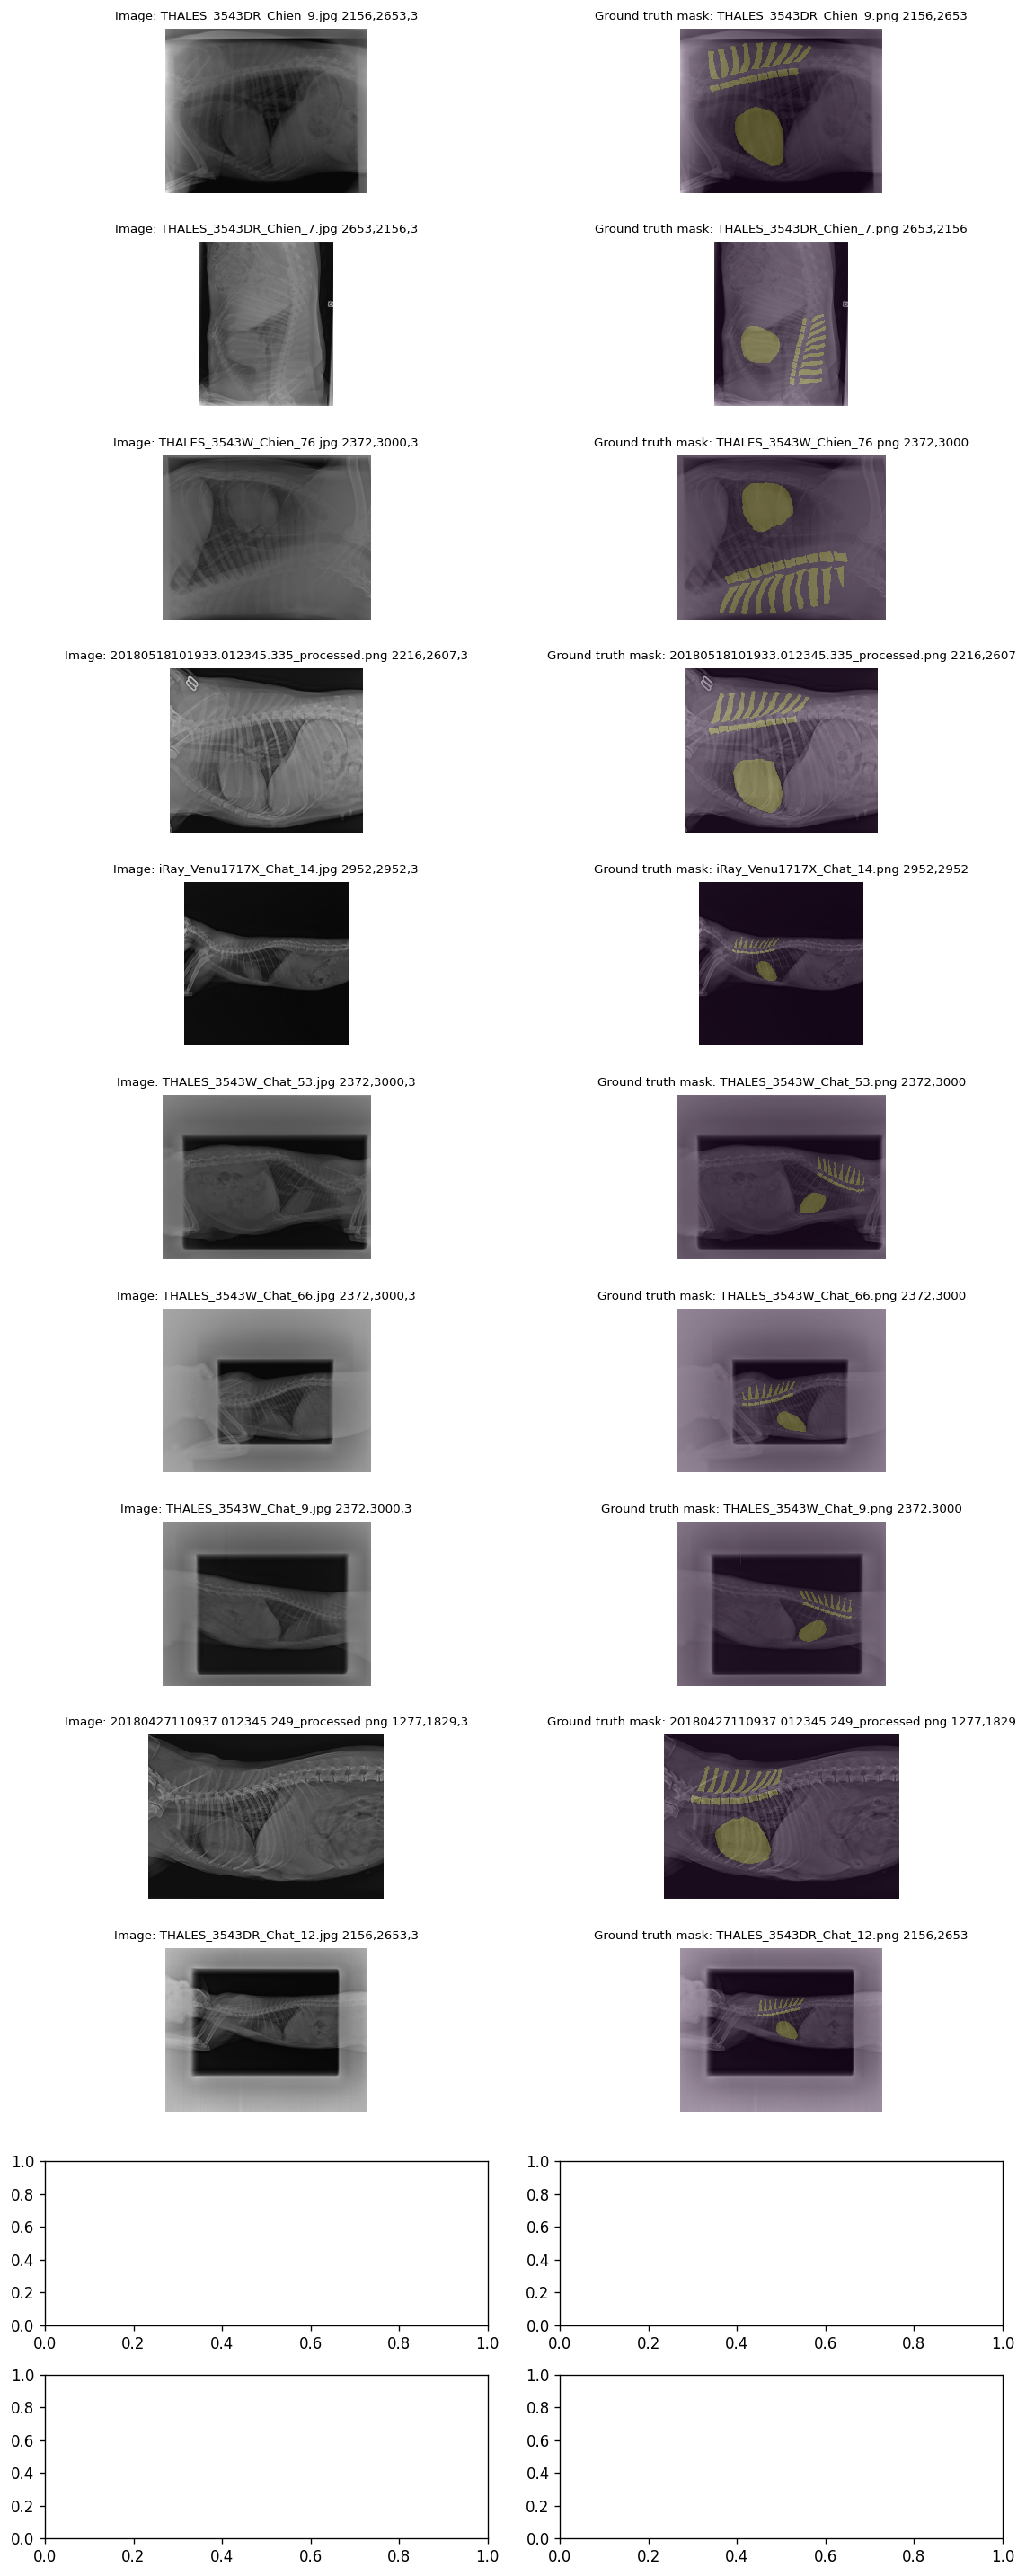

In [ ]:
#14
#affichage de quelques radios segmentées de notre jeu de données de test.
display_image_grid_3masks(test_images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P)

In [ ]:
#15
# fonction pour afficher les 10 radios de test ainsi que leur masques vérités terrain en utilisant la bibliothèque PIL.
plt.rcParams['figure.dpi'] = 120

def display_image_grid_3masks_PIL(images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P ,predicted_masks=None):
    j=0
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))        
      

        if image_filename.split('.')[1]=='jpg':
          mask_file=image_filename.replace(".jpg", ".png")
          mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)
        else:
          mask_file=image_filename
          mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
          mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)

        
      
        radio = cv2.imread(os.path.join(images_directory, image_filename), cv2.IMREAD_UNCHANGED,)
       

        mask_C1=preprocess_mask(mask_C)
        mask_V1=preprocess_mask(mask_V)
        mask_P1=preprocess_mask(mask_P)
        mask1= mask_C1+mask_V1+mask_P1 
        img_mask1 = Image.fromarray(np.uint8((mask1)*255))
        img_radio = Image.fromarray(np.uint8(radio))
        img_radio.paste(img_mask1, mask=img_mask1)

        ax[i, 0].imshow(image)

        ax[i, 1].imshow(img_radio)

       

        ax[i, 0].set_title("Image: " + image_filename +  " "+ ",".join(str(x) for x in image.shape) , fontsize=8)
        
        ax[i, 1].set_title("Ground truth mask: " + mask_file + " "+ ",".join(str(x) for x in mask1.shape) , fontsize=8)

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask" + " "+ ",".join(str(x) for x in predicted_mask.shape), fontsize=8 )
            ax[i, 2].set_axis_off()
        j +=1
        if j==10:
          break

    plt.tight_layout()
    plt.show()


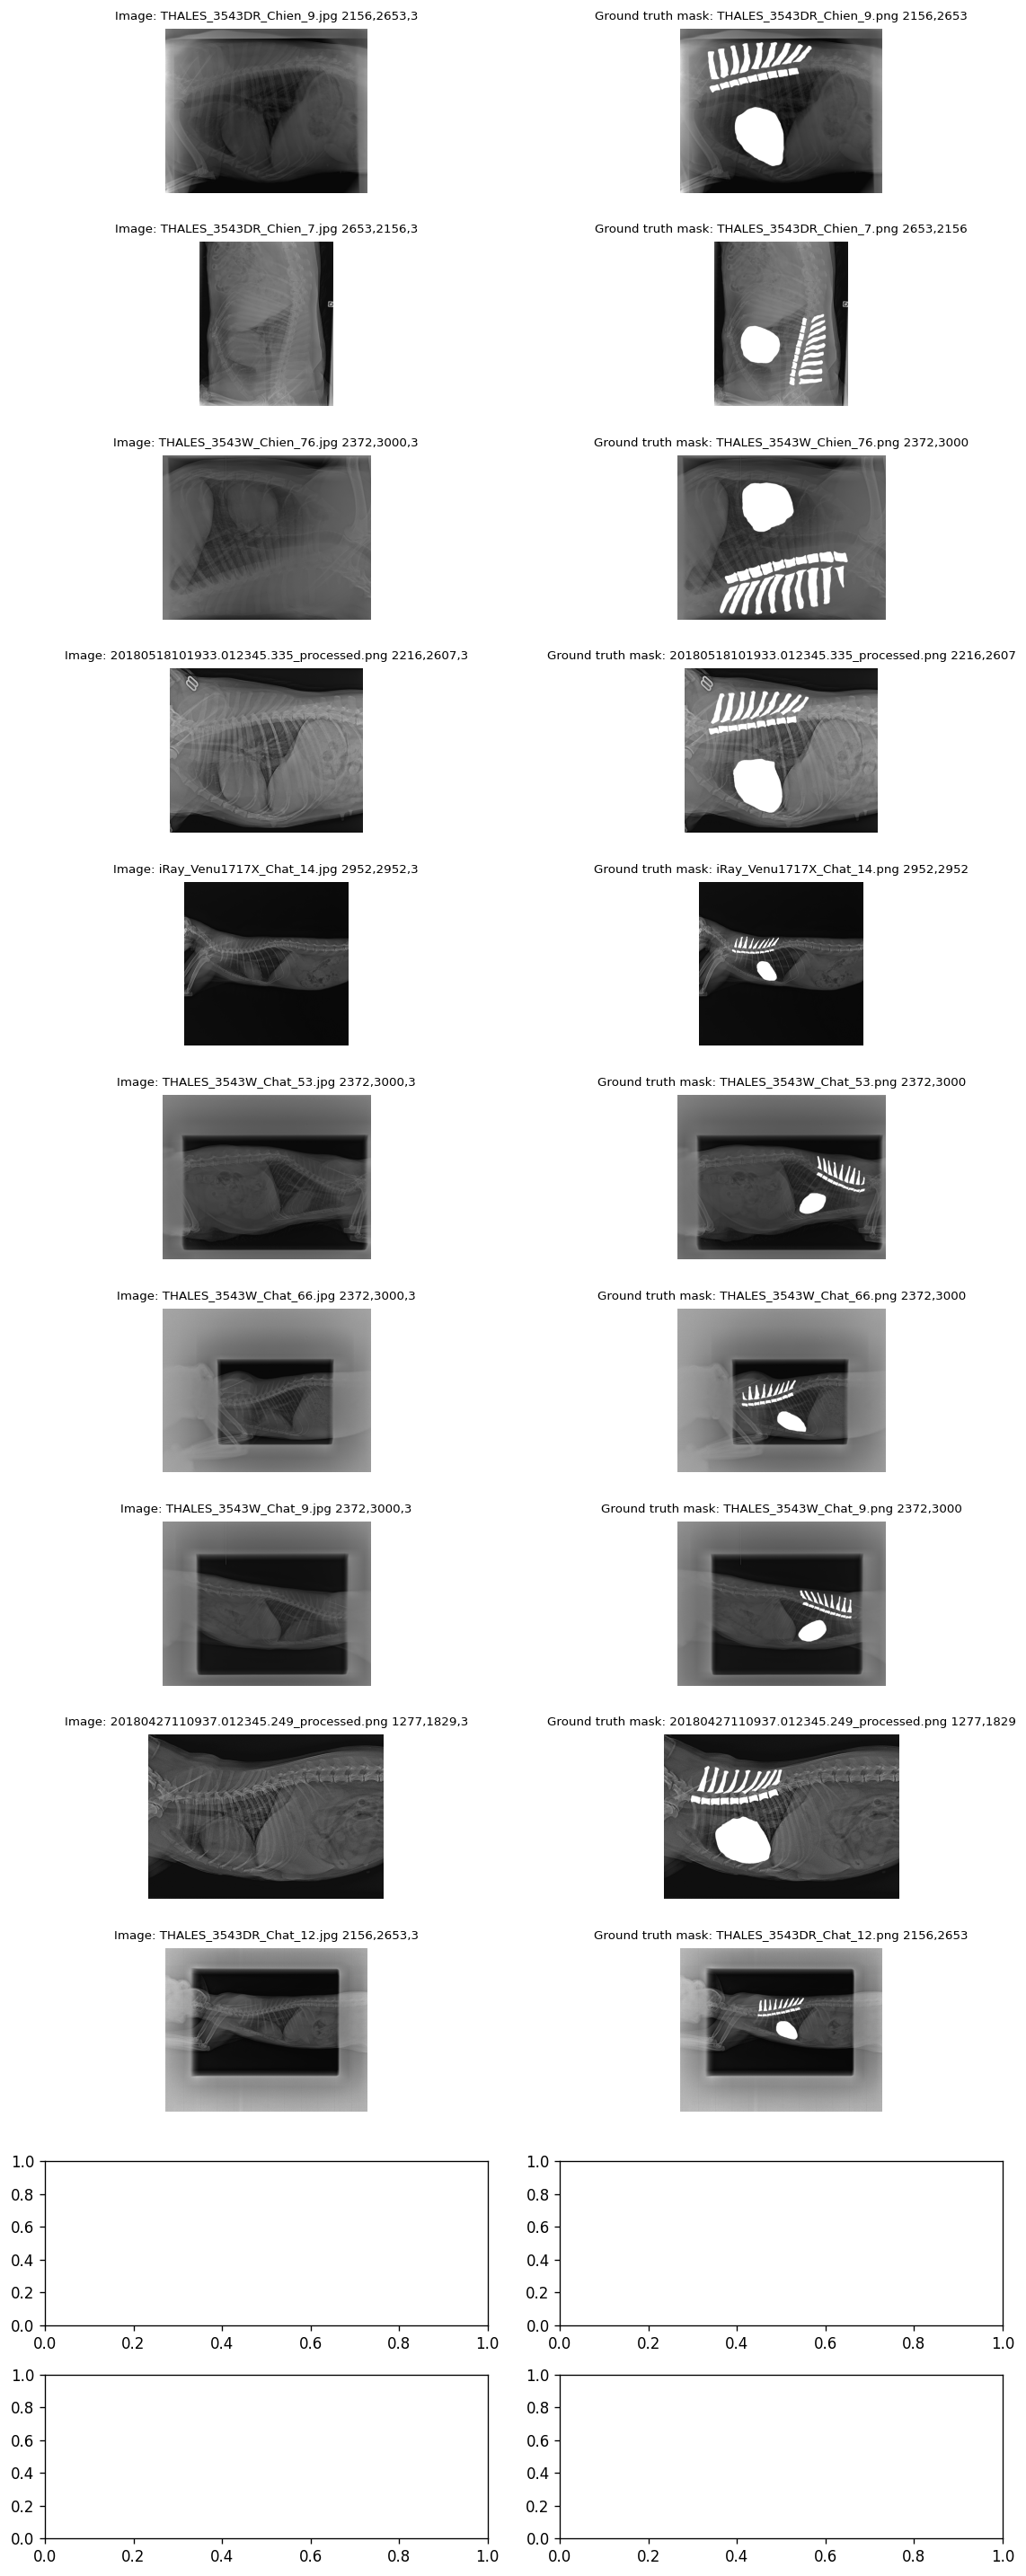

In [ ]:
#16
#affichage des 10 radios de test ainsi que leur masques vérités terrain en utilisant la bibliothèque PIL.
display_image_grid_3masks_PIL(test_images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P)

In [ ]:
#17
# nouveau modèle  avec 124 millions de paramètres
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)


        self.down_conv_6 = double_conv(1024, 2048)
        
        self.up_trans_0 = nn.ConvTranspose2d(
            in_channels=2048,
            out_channels=1024,
            kernel_size=2,
            stride=2
        )
        self.up_conv_0 = double_conv(2048, 1024)


        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
      
        x1 = self.down_conv_1(image)
       
        x2 = self.max_pool_2x2(x1)
        
        x3 = self.down_conv_2(x2)
       
        x4 = self.max_pool_2x2(x3)
       
        x5 = self.down_conv_3(x4)
       
        x6 = self.max_pool_2x2(x5)
      
        x7 = self.down_conv_4(x6)        
     
        x8 = self.max_pool_2x2(x7)
   
        x9 = self.down_conv_5(x8)
      


        x10 = self.max_pool_2x2(x9)
      
        x11 = self.down_conv_6(x10)   
      
       
        x = self.up_trans_0(x11)
        
        x = self.up_conv_0(torch.cat([x9, x], 1))        
            
        x = self.up_trans_1(x9)
      
        x = self.up_conv_1(torch.cat([x7, x], 1))        
       
        
        x = self.up_trans_2(x)

        x = self.up_conv_2(torch.cat([x5, x], 1))
      
        
        
        x = self.up_trans_3(x)
       
        x = self.up_conv_3(torch.cat([x3, x], 1))
       
        
        x = self.up_trans_4(x)
    
        x = self.up_conv_4(torch.cat([x1, x], 1))
    
        
        x = self.out(x)
  
        return x.to(DEVICE)

In [ ]:
 #18
 DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
 model = UNet()

In [ ]:
#19
# affichage du modèle
from torchsummary import summary
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(DEVICE)
summary(model, (3, 1024, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 64, 1024, 1024]           1,792
       BatchNorm2d-2       [-1, 64, 1024, 1024]             128
              ReLU-3       [-1, 64, 1024, 1024]               0
            Conv2d-4       [-1, 64, 1024, 1024]          36,928
       BatchNorm2d-5       [-1, 64, 1024, 1024]             128
              ReLU-6       [-1, 64, 1024, 1024]               0
         MaxPool2d-7         [-1, 64, 512, 512]               0
            Conv2d-8        [-1, 128, 512, 512]          73,856
       BatchNorm2d-9        [-1, 128, 512, 512]             256
             ReLU-10        [-1, 128, 512, 512]               0
           Conv2d-11        [-1, 128, 512, 512]         147,584
      BatchNorm2d-12        [-1, 128, 512, 512]             256
             ReLU-13        [-1, 128, 512, 512]               0
        MaxPool2d-14        [-1, 128, 2

In [ ]:
# 20
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions


In [ ]:
# 21
# les hyper paramètres
params = {
    "device": "cuda",
    "lr": 0.001,     
    "batch_size": 2,
    "num_workers": 2,
}

In [ ]:
#22
# chargement du modèle de prédiction des masques des coeurs après 550 epochs
ROOT=pathlib.Path.cwd() / 'drive/MyDrive/PTRANS2'
path_C=ROOT / "Dev/output/model_01052022_Coeur_UNET_2048_BCEWithLogits_epochs550_lr_1e-3.pth"
model_C= torch.load(path_C)
model_C.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [ ]:
#23
# chargement du modèle de prédiction des masques des vertèbres après 1200 epochs
path_V=ROOT / "Dev/output/model_10052022_Vertebres_UNET_2048_BCEWL_epochs1200_posweight20.pth"
model_V= torch.load(path_V)
model_V.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [ ]:
#24
# chargement du modèle de prédiction des masques des processus épineux après 850 epochs
path_P=ROOT / "Dev/output/model_10052022_Process_UNET_2048_BCEWL_epochs850.pth"
model_P= torch.load(path_P)
model_P.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [ ]:
#25
# la classe Dataset ci-dessous va permettre de faire les prédictions.

class BuchananPredictionDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):

        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self,idx):
      
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        original_size = tuple(image.shape[:2])
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            radio = augmentations['image']
            
        return radio,original_size

In [ ]:
#26
#les transformations à appliquer au test set pour pouvoir le tester

SIZE=1024
test_transform = A.Compose([
    A.LongestMaxSize(SIZE),
    A.PadIfNeeded(min_height=SIZE, min_width=SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
test_dataset = BuchananPredictionDataset(test_images_filenames, images_directory, transform=test_transform,)

In [ ]:
#27
# prédictions des masques des coeurs, des vertébres et des processus pour les 10 radios de test

predictions_C  = predict(model_C, params, test_dataset, batch_size=2)
predictions_V  = predict(model_V, params, test_dataset, batch_size=2)
predictions_P  = predict(model_P, params, test_dataset, batch_size=2)

In [ ]:
#28
# appliquer les dimensions d'origine aux prédictions des coeurs
predicted_masks_C = []
for predicted_1024x1024_mask, original_height, original_width in predictions_C:
    full_sized_mask = cv2.resize(        
        predicted_1024x1024_mask, (original_width,original_height), interpolation=cv2.INTER_NEAREST
    )
    predicted_masks_C.append(full_sized_mask)

In [ ]:
#29
# appliquer les dimensions d'origine aux prédictions des vertèbres
predicted_masks_V = []
for predicted_1024x1024_mask, original_height, original_width in predictions_V:
    full_sized_mask = cv2.resize(        
        predicted_1024x1024_mask, (original_width,original_height), interpolation=cv2.INTER_NEAREST
    )
    predicted_masks_V.append(full_sized_mask)

In [ ]:
#30
# appliquer les dimensions d'origine aux prédictions des processus
predicted_masks_P = []
for predicted_1024x1024_mask, original_height, original_width in predictions_P:
    full_sized_mask = cv2.resize(        
        predicted_1024x1024_mask, (original_width,original_height), interpolation=cv2.INTER_NEAREST
    )
    predicted_masks_P.append(full_sized_mask)

In [ ]:
#31
# on a intégré les 3 masques du coeur, des vertèbres et des processus dans un même masque pour les 10 radios de test
predicted_masks = []
for i in range(12):
  predicted_masks.append(predicted_masks_C[i] + predicted_masks_V[i] + predicted_masks_P[i])

In [ ]:
#31
# fonction pour afficher les 10 radios de test avec leur masques vérités terrain ainsi les radios de test avec les 3 masques prédits
plt.rcParams['figure.dpi'] = 120
def display_image_grid_3masks_predict(images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P ,predicted_masks=None):
    cols = 2 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    j=0
    
    for i, image_filename in enumerate(images_filenames):
        if j<=9:
          if image_filename.split('.')[1]=='jpg':
              mask_file=image_filename.replace(".jpg", ".png")
              mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
              mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
              mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)
          else:
              mask_file=image_filename
              mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
              mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
              mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)
    
        radio = cv2.imread(os.path.join(images_directory, image_filename), cv2.IMREAD_UNCHANGED,)
       

        mask_C1=preprocess_mask(mask_C)
        mask_V1=preprocess_mask(mask_V)
        mask_P1=preprocess_mask(mask_P)
        mask1= mask_C1+mask_V1+mask_P1 

        ax[i, 0].imshow(radio)
        ax[i, 0].set_axis_off()
        if j<=9:
          

          ax[i, 0].imshow(mask1, interpolation="nearest",alpha=0.2, cmap='gray')

        
          ax[i, 0].set_title("Ground truth mask: " + mask_file + " "+ ",".join(str(x) for x in mask1.shape) , fontsize=8)

          

        
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 1].imshow(radio)
            ax[i, 1].imshow(predicted_mask, interpolation="nearest",alpha=0.3)
            ax[i, 1].set_title("Predicted mask" + " "+ ",".join(str(x) for x in predicted_mask.shape), fontsize=8 )
            ax[i, 1].set_axis_off()
        j +=1
        
        
    plt.tight_layout()
    plt.show()


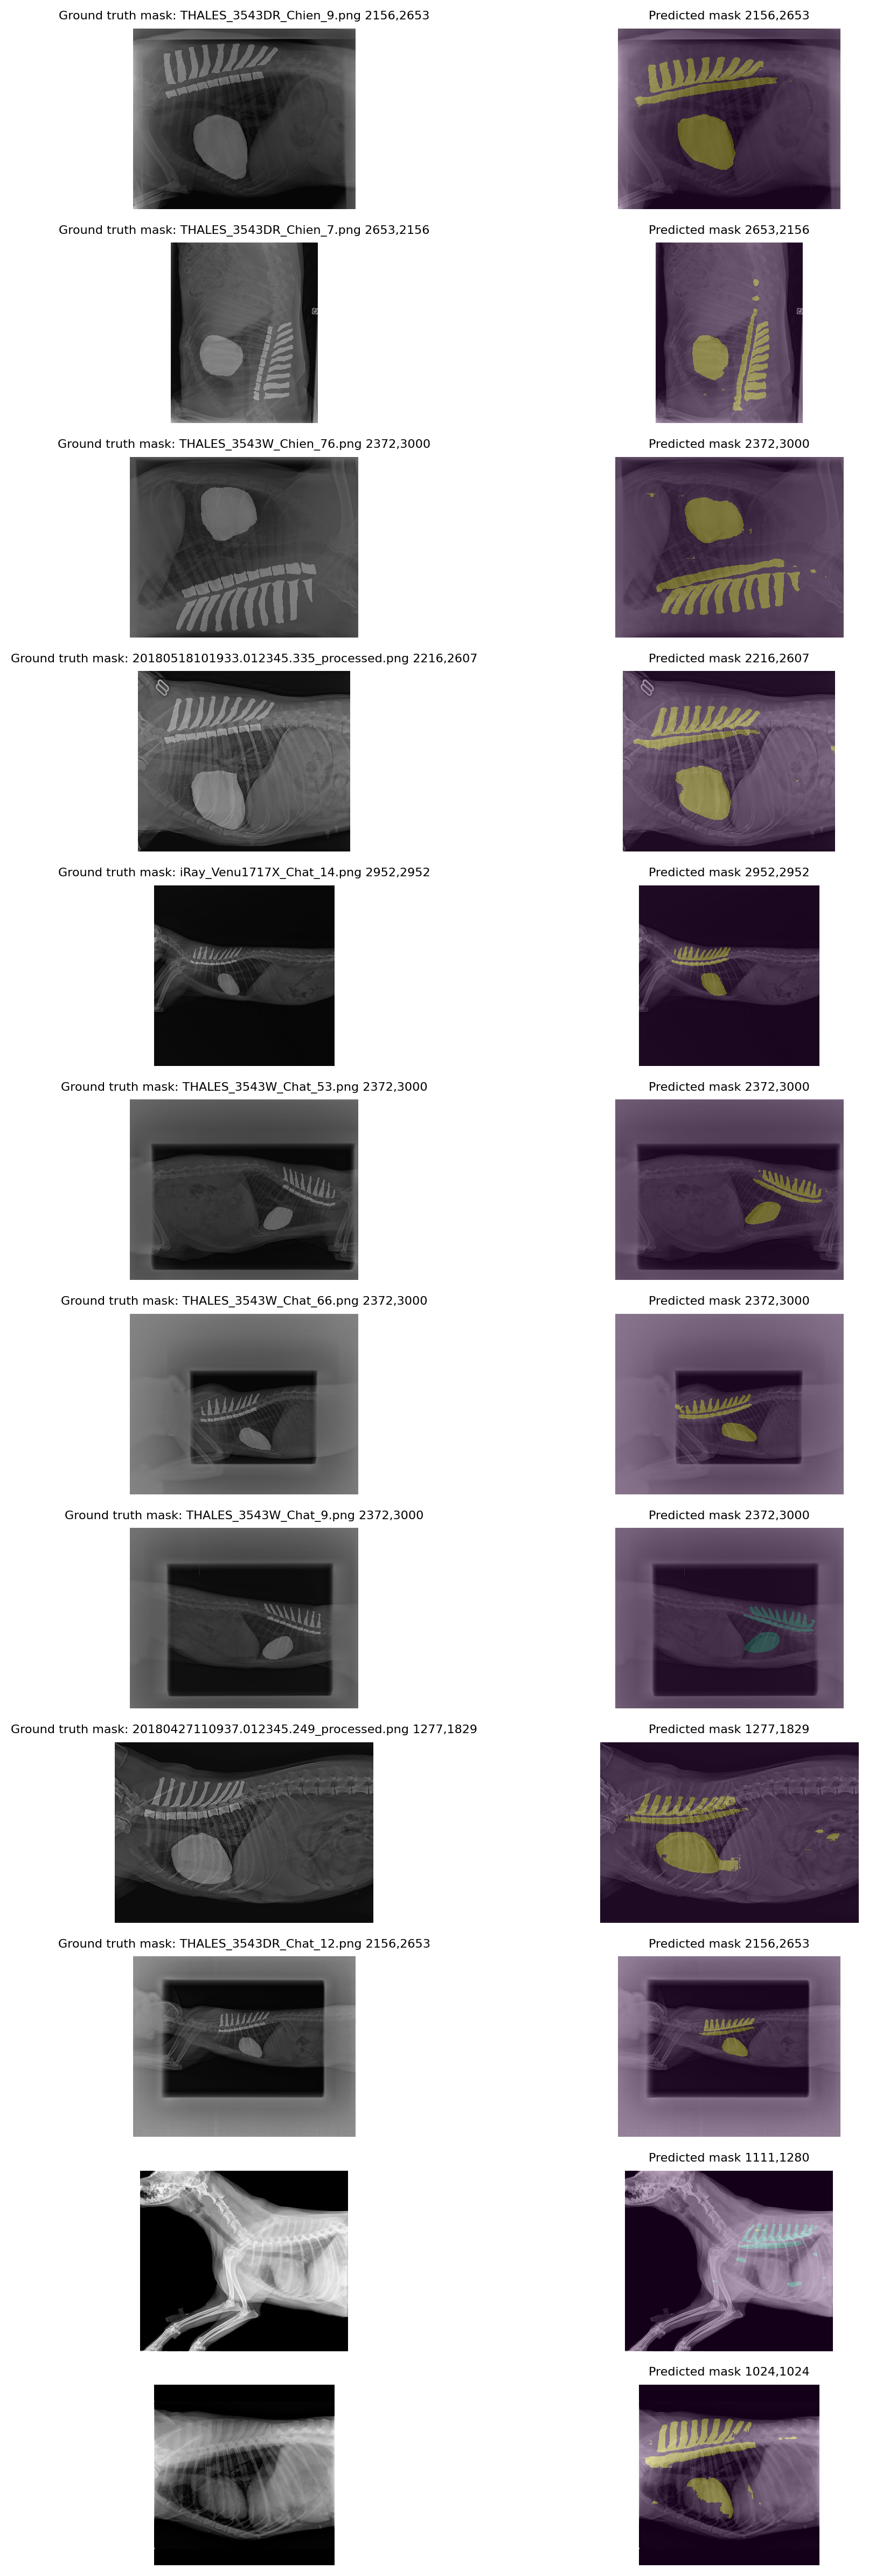

In [ ]:
#32
#affichage des 3 prédictions ensemble
plt.rcParams['figure.dpi'] = 200
display_image_grid_3masks_predict(test_images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P,predicted_masks=predicted_masks)

In [ ]:
#33
# fonction pour afficher les 10 radios de test avec leur masques vérités terrain ainsi les radios de test avec les 3 masques prédits en passant par la bibliothèque PIL.

plt.rcParams['figure.dpi'] = 120
def display_image_grid_3masks_predict_PIL(images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P ,predicted_masks=None):
    cols = 2 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    j=0
    for i, image_filename in enumerate(images_filenames):
        if j<=9:
          if image_filename.split('.')[1]=='jpg':
            mask_file=image_filename.replace(".jpg", ".png")
            mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
            mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
            mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)
          else:
            mask_file=image_filename
            mask_C = cv2.imread(os.path.join(masks_directory_C, mask_file), cv2.IMREAD_UNCHANGED,)
            mask_V = cv2.imread(os.path.join(masks_directory_V, mask_file), cv2.IMREAD_UNCHANGED,)
            mask_P = cv2.imread(os.path.join(masks_directory_P, mask_file), cv2.IMREAD_UNCHANGED,)

        
     
        radio = cv2.imread(os.path.join(images_directory, image_filename), cv2.IMREAD_UNCHANGED,)
       

        
        img_radio = Image.fromarray(np.uint8(radio))
        
        

        
        ax[i, 0].set_axis_off()
        
        
        ax[i, 0].imshow(img_radio)

        if j<=9:
          
          mask_C1=preprocess_mask(mask_C)
          mask_V1=preprocess_mask(mask_V)
          mask_P1=preprocess_mask(mask_P)
          mask1= mask_C1+mask_V1+mask_P1 
          img_mask1 = Image.fromarray(np.uint8((mask1)*255))
          img_radio.paste(img_mask1, mask=img_mask1)
          ax[i, 0].imshow(img_radio)
        
          ax[i, 0].set_title("GGround truth mask: " + mask_file + " "+ ",".join(str(x) for x in mask1.shape) , fontsize=8)

        

        if predicted_masks:
            radio = cv2.imread(os.path.join(images_directory, image_filename), cv2.IMREAD_UNCHANGED,)
            img_radio = Image.fromarray(np.uint8(radio))
            predicted_mask = predicted_masks[i]
            img_predict_mask = Image.fromarray(np.uint8((predicted_mask)*255))
            img_radio.paste(img_predict_mask, mask=img_predict_mask)
            ax[i, 1].imshow(img_radio)
            ax[i, 1].set_title("Predicted mask" + " "+ ",".join(str(x) for x in predicted_mask.shape), fontsize=8 )
            ax[i, 1].set_axis_off()
        j+=1
     
    plt.tight_layout()
    plt.show()


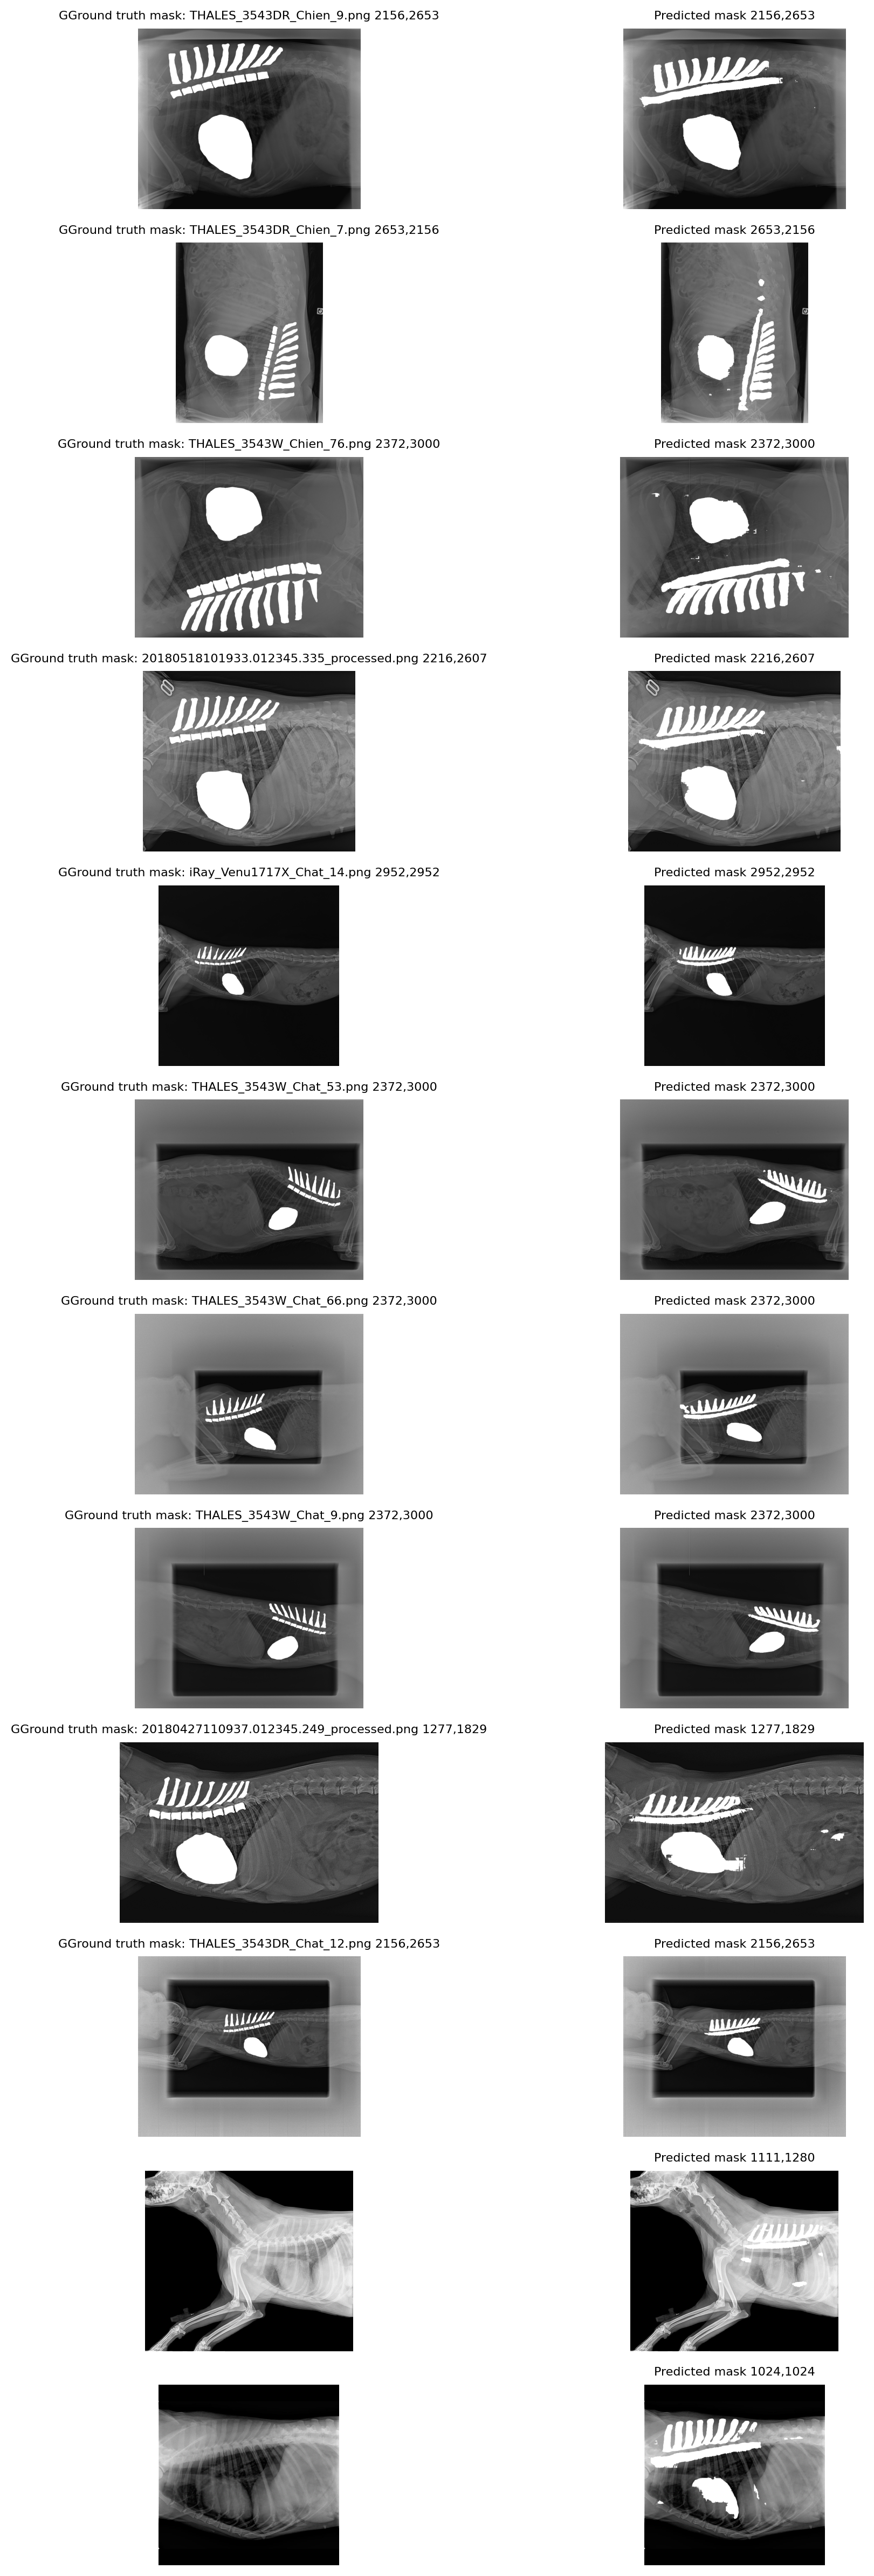

In [ ]:
#34
#affichage des 3 prédictions ensemble appliquées sur le test set en utilisant la biblipthèque PIL
plt.rcParams['figure.dpi'] = 200
display_image_grid_3masks_predict_PIL(test_images_filenames, images_directory, masks_directory_C,masks_directory_V,masks_directory_P,predicted_masks=predicted_masks)
